# MNIST classification
This lecture demonstrates an example of a classification instance using Tensorflow.



# MNIST data
​
MNIST is a collection of images of handwritten numerical digits. Each image is 28x28 pixels and each has a grayscale value from 0-255.

In [4]:
import numpy as np;
import matplotlib
import matplotlib.pyplot as plt


mnist = np.load('mnist_data.npz')


X_train = mnist['X_train']
X_test = mnist['X_test']
y_train = mnist['y_train']
y_test = mnist['y_test']



We have 60000 28x28 images in our training set and 10000 in the test set.

In [5]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


The pixel value range is 0-255

In [6]:
print(X_train[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

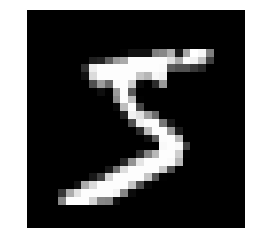

In [7]:
plt.imshow(X_train[0],cmap='gray')
plt.axis('off')
plt.show()

Let's see what they look like:

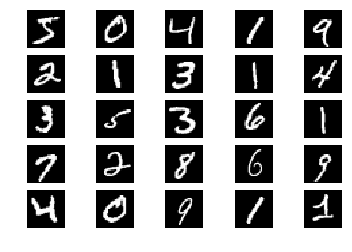

In [8]:
sz = 5;

for i in range(sz*sz):

    plt.subplot(sz, sz, i+1)
    plt.imshow(X_train[i],cmap='gray')
    plt.axis('off')

plt.show()

The dataset also includes a label for each digit:

In [9]:
print(y_train[:sz*sz].reshape([sz,sz]))

[[5 0 4 1 9]
 [2 1 3 1 4]
 [3 5 3 6 1]
 [7 2 8 6 9]
 [4 0 9 1 1]]


# Pre-processing
We will flatten each digit into a 784-dimensional vector.

In [10]:
train_data = X_train.reshape([-1,28*28])
test_data = X_test.reshape([-1,28*28])

print(train_data.shape)
print(test_data.shape)

(60000, 784)
(10000, 784)


We will normalize the data to the [0,1] range:

In [11]:

def normalize_data(x):
	flat_x = np.reshape(x,[-1]);
	L = np.min(x);
	H = np.max(x);
    
	return (x.astype(np.float32)-L)/(H-L);

train_data = normalize_data(train_data)
test_data = normalize_data(test_data)

print(train_data[0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

We also need to convert the labels into a 1-hot representation:

In [12]:
def to_one_hot(labels,num):
    one_hot_labels = np.zeros((labels.shape[0],num))
    one_hot_labels[np.arange(labels.shape[0]),labels] = 1.0
    return one_hot_labels;

                              
train_labels = to_one_hot(y_train,10)
test_labels = to_one_hot(y_test,10)

print('Initial labels:')
print(y_train[:5])
print('1-hot representation:')
print(train_labels[:5])

Initial labels:
[5 0 4 1 9]
1-hot representation:
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


# Building a model

First let's import tensorflow:

In [13]:
import tensorflow as tf

The model will take the flattened digit as input. An input is declared as a "placeholder" variable meaning that the value of this tensor will be provided at run-time. For the computation of the loss function the class labels are also considered inputs to the model:

In [14]:
x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

We will feed the input into a two dense layers with a tanh() non-linearity. Each layer consists of the weight matrix W and the bias vector b. These have to be declared as variables:

In [15]:
h1_sz = 64;

W1 = tf.get_variable("W1", [784,h1_sz])
b1 = tf.Variable(tf.zeros([h1_sz]))
h1 = tf.matmul(x,W1) + b1

h1 = tf.tanh(h1)

W2 = tf.get_variable("W2", [h1_sz,10])
b2 = tf.Variable(tf.zeros([10]))
h2 = tf.matmul(h1,W2) + b2


The activations of the layer are fed into a soft-max layer that outputs class probabilities:

In [16]:
class_probs = tf.nn.softmax(h2)

We will use the cross-entropy between the predicted and the actual labels as our loss function:

In [17]:
cross_entropy_loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(tf.nn.softmax(class_probs)),axis=[1]))

We also need to define what a training step looks like. The command below tells tensorflow to optimize the loss function using a Stochastic Gradient Descent (SGD) step with a learning rate of 0.5:

In [18]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy_loss)

We need to create a session that will run on the computational graph:

In [19]:
sess = tf.InteractiveSession()

We also need to initialize the variables of the model:

In [20]:
tf.global_variables_initializer().run()

We can use the session to feed the input to the model and get the value of a specific node:

In [21]:

batch_x = train_data[:5]
batch_y = train_labels[:5]

vis_probs = sess.run([class_probs], feed_dict={x:batch_x})

print(vis_probs)

[array([[0.07023024, 0.22203842, 0.07138369, 0.0723135 , 0.12526295,
        0.06274264, 0.04892712, 0.11890938, 0.08668835, 0.12150362],
       [0.04212927, 0.40963838, 0.08612484, 0.04908083, 0.12183166,
        0.06481547, 0.03213869, 0.04486589, 0.04813111, 0.10124389],
       [0.16606636, 0.13154069, 0.09132574, 0.05616323, 0.17327347,
        0.10721041, 0.08139318, 0.05838852, 0.05561564, 0.07902271],
       [0.06164303, 0.08847947, 0.09353473, 0.1743799 , 0.12460134,
        0.05612553, 0.06958399, 0.09133579, 0.1677432 , 0.07257301],
       [0.05330674, 0.11940192, 0.06932399, 0.11645781, 0.17480846,
        0.06931475, 0.02471524, 0.16119638, 0.14329083, 0.06818389]],
      dtype=float32)]


Notice how we did not provide the labels since these are not part of the slice of the computational graph for the class probabilities.

We can also perform an SGD step on this batch by running the session on the training step:

In [22]:
for j in range(200):
    [a,vis_probs] = sess.run([train_step,class_probs], feed_dict={x:batch_x,y:batch_y})
print(vis_probs)

[[2.5329928e-04 2.1613027e-04 8.6133747e-05 1.0627703e-04 5.3516658e-05
  9.9902332e-01 4.6226862e-05 6.4939828e-05 3.0821760e-05 1.1949651e-04]
 [9.9896991e-01 9.9090837e-05 7.2161587e-05 2.6897806e-05 1.6319845e-04
  1.8013945e-04 2.6216914e-04 8.0080310e-05 3.9489620e-05 1.0689260e-04]
 [1.3559053e-04 6.5113709e-05 2.2252667e-05 6.4583524e-05 9.9910611e-01
  9.3421710e-05 8.0781465e-05 1.2213223e-04 9.5233496e-05 2.1477927e-04]
 [6.7547844e-05 9.9891150e-01 2.0857913e-04 5.0560269e-05 4.5560628e-05
  2.9069520e-04 2.4694746e-05 6.9191243e-05 9.7746764e-05 2.3403548e-04]
 [1.6987254e-04 2.1271058e-04 5.6172303e-05 4.9478796e-05 2.2423583e-04
  7.9809230e-05 7.7910365e-05 1.1220664e-04 1.1972915e-04 9.9889791e-01]]


Notice how re-running the command above shifts the output of the model towards the actual labels. Of course this instance of the model will be horribly overfit to these few digits. Let's re-initialize the model:

In [23]:
tf.global_variables_initializer().run()

Instead we will cycle over the whole training dataset a few times. We will process the dataset in mini-batches and take an SGD step for each such mini-batch.

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4


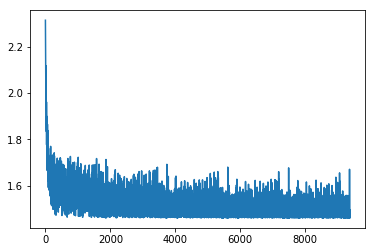

In [24]:
epochs = 5;

batch_size = 32;

N = train_data.shape[0];

hist_loss = [];

for epoch in range(epochs):
	print("Epoch:", epoch)

	for index in range(int(N/(batch_size))):
        
		batch_x = train_data[index*batch_size:(index+1)*batch_size];
		batch_y = train_labels[index*batch_size:(index+1)*batch_size];
        
		[vis_loss,a] = sess.run([cross_entropy_loss,train_step], feed_dict={x:batch_x,y:batch_y})
		hist_loss += [vis_loss]
        
plt.plot(hist_loss)
plt.show()

Let's see what the model learns:

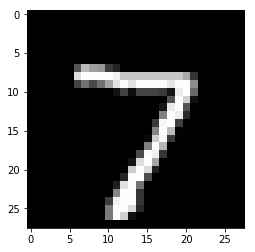

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[[2.8940707e-07 5.3264776e-13 2.4204306e-07 1.6452760e-06 2.6299982e-12
  4.9780136e-09 6.9651573e-14 9.9999404e-01 1.4689489e-07 3.6739843e-06]]



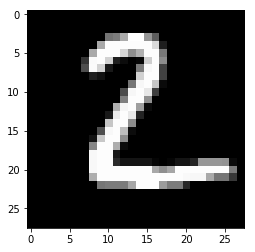

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[[1.1039261e-06 1.3627464e-07 9.9993718e-01 6.0553368e-05 2.1338861e-14
  1.1185938e-07 6.5021300e-07 1.7365842e-15 3.2880061e-07 2.8522215e-14]]



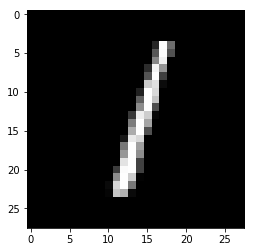

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[[9.6947256e-11 9.9993539e-01 2.1386715e-05 2.7611506e-05 1.2257561e-08
  8.0157591e-08 1.5843309e-06 4.4914555e-07 1.3411585e-05 6.6068516e-08]]



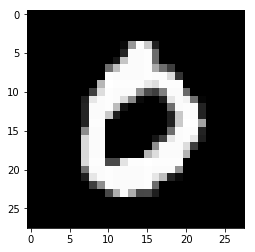

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[9.9999261e-01 1.0184946e-12 5.6730848e-08 3.1666062e-08 4.5362447e-13
  4.2472020e-06 2.0489083e-06 1.0964062e-07 1.1105469e-08 7.9157076e-07]]



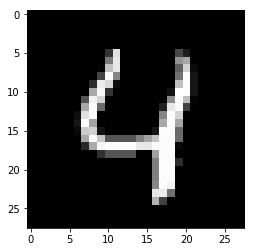

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[[2.9265235e-09 1.1105095e-13 7.9548158e-08 1.9266826e-11 9.9859494e-01
  2.4473434e-09 7.9018031e-07 4.2891534e-06 4.9187770e-06 1.3948668e-03]]



In [25]:
for j in range(5):
    digit = test_data[j].reshape([1,784]);
    actual_label = test_labels[j];
    
    plt.imshow(digit.reshape([28,28]),cmap='gray')
    plt.show()
    print(actual_label)
    
    [vis_probs] = sess.run([class_probs], feed_dict={x:digit})
    print(vis_probs)
    input()

To test the model more 'formally' we can compute the accuracy on the test dataset:

In [26]:
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(class_probs, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

train_accuracy = sess.run(accuracy,feed_dict={x:train_data,y:train_labels})
test_accuracy = sess.run(accuracy,feed_dict={x:test_data,y:test_labels})

print("Accuracy on training data:",train_accuracy)
print("Accuracy on test data:",test_accuracy)

Accuracy on training data: 0.97026664
Accuracy on test data: 0.9615
